<center>

## Introduction to Python 

 ####  The aim of our project is to implement Stochastic Hill climbing optimization algorithm and Feature selection with stochastic optimization algorithm 

</center>


<center>

## Part-1
### Stochastic Hill climbing

<img src="samosa.jpg" height="240" width="240">
<img src="test3.jpg" height="240" width="240">
<img src="test.jpg" height="240" width="240">

#### These are the images where we are going to perform this algorithm

</center>


### Importing Libraries


- **Pillow (PIL)**: A library for working with images—opening, editing, and saving them.
- **NumPy**: A library for handling arrays and performing math operations.
- **Matplotlib**: A library for making plots and visualizations.
- **Random**: A module for generating random numbers and choices.
- **Copy**: A module for making deep copies of objects to avoid changes to the original.


In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import copy


### Grid size for the puzzle
`grid_size = 3` sets the number of rows and columns in the puzzle grid. This means:

- The image will be split into a 3x3 grid, creating 9 smaller pieces.
- Each row and column of the puzzle will have 3 pieces.

You can adjust `grid_size` to split the image into a different number of pieces, such as 4x4 or 5x5, by changing the value to 4, 5, etc.

In [25]:
grid_size = 3

### Step 1: Split the image into pieces
The `split_image` function takes an image and divides it into smaller pieces based on the `grid_size`. 

1. **Open the Image**: The function loads the image from the provided file path using `Image.open(image_path)`.

2. **Calculate Piece Size**: The width of each piece is determined by dividing the image width by `grid_size`. This ensures that the image is split evenly into a grid.

3. **Split the Image**: The function uses two nested loops to iterate over each row and column of the grid:
   - For each piece, it crops the image using `image.crop()` based on the current grid position.
   - The cropped piece is converted into a NumPy array (`np.array()`) and added to the `pieces` list.

4. **Return**:
   - A 2D list (`pieces`) representing the image split into rows and columns.
   - The width of each piece (`piece_width`), which is useful for reassembling the image later.

This function prepares the image pieces for the puzzle-solving process by creating a grid of smaller image sections.

In [26]:
def split_image(image_path, grid_size):
    image = Image.open(image_path)
    piece_width = image.width // grid_size
    pieces = []
    for i in range(grid_size):
        row = []
        for j in range(grid_size):
            piece = image.crop((j * piece_width, i * piece_width, 
                                (j + 1) * piece_width, (i + 1) * piece_width))
            row.append(np.array(piece))
        pieces.append(row)
    return pieces, piece_width

### Step 2: Calculate mismatch
The `calculate_mismatch` function measures how well two adjacent image pieces fit together by comparing their pixel values at the edges.
### Function Details:
- **Inputs**:
  - `piece1` and `piece2`: NumPy arrays representing two image pieces.
  - `side`: A string indicating which side to compare: `'right'` or `'bottom'`.

### How It Works:
1. **Right Side Comparison**:
   - If `side` is `'right'`, the function compares the right edge of `piece1` with the left edge of `piece2`.
   - It calculates the difference between the pixel values of the last column of `piece1` and the first column of `piece2`.
   - `np.sum(np.abs(piece1[:, -1, :] - piece2[:, 0, :]))` computes the total sum of pixel differences across all color channels.

2. **Bottom Side Comparison**:
   - If `side` is `'bottom'`, it compares the bottom edge of `piece1` with the top edge of `piece2`.
   - It calculates the difference between the last row of `piece1` and the first row of `piece2`.
   - `np.sum(np.abs(piece1[-1, :, :] - piece2[0, :, :]))` computes the total sum of pixel differences.

3. **Return Value**:
   - The function returns the total pixel difference between the edges of the two pieces. A lower value means the pieces fit together better, while a higher value indicates a poor fit.

### Purpose:
The `calculate_mismatch` function helps assess the quality of the puzzle configuration by quantifying how well adjacent pieces align at their edges. This metric is essential for finding an optimal arrangement in the puzzle-solving process.

In [27]:
def calculate_mismatch(piece1, piece2, side):
    """Calculate pixel mismatch on the given side: 'right' or 'bottom'."""
    if side == 'right':
        return np.sum(np.abs(piece1[:, -1, :] - piece2[:, 0, :]))  # Right edge of piece1 vs left edge of piece2
    elif side == 'bottom':
        return np.sum(np.abs(piece1[-1, :, :] - piece2[0, :, :]))  # Bottom edge of piece1 vs top edge of piece2
    return 0

### Step 3: Calculate total mismatch
1. **Initialization**:
   - `total_mismatch` is set to `0` to start counting mismatches.

2. **Nested Loops**:
   - The function iterates over each piece in the `puzzle` grid using two nested loops (`for i` for rows and `for j` for columns).

3. **Right Neighbor Check**:
   - If `j < grid_size - 1`, it means the current piece has a right neighbor.
   - Calls `calculate_mismatch()` for the current piece and its right neighbor, adding the result to `total_mismatch`.

4. **Bottom Neighbor Check**:
   - If `i < grid_size - 1`, the current piece has a bottom neighbor.
   - Calls `calculate_mismatch()` for the current piece and the piece below it, adding the result to `total_mismatch`.

5. **Return Value**:
   - Returns the `total_mismatch`, which represents how well the current puzzle configuration fits together. Lower values mean a better fit.

### Purpose:
This function evaluates the quality of the entire puzzle layout by summing up mismatches for all adjacent piece pairs. It guides optimization algorithms by showing which configurations have lower mismatch scores, indicating better fits.

In [28]:
def calculate_total_mismatch(puzzle):
    """Calculate total mismatch for the whole puzzle configuration."""
    total_mismatch = 0
    for i in range(grid_size):
        for j in range(grid_size):
            if j < grid_size - 1:  # Right neighbor
                total_mismatch += calculate_mismatch(puzzle[i][j], puzzle[i][j + 1], 'right')
            if i < grid_size - 1:  # Bottom neighbor
                total_mismatch += calculate_mismatch(puzzle[i][j], puzzle[i + 1][j], 'bottom')
    return total_mismatch

### Step 4: Hill Climbing with enhancements
1. **Initialization**:
   - Copies the initial puzzle as `best_solution` and evaluates it as `best_eval`.
   - Tracks evaluation scores in `scores`.
   - Sets counters for no improvements and restarts.

2. **Iterations**:
   - For each iteration (up to `n_iterations`):
     - Randomly selects two distinct pieces to swap.
     - Swaps the pieces and evaluates the new puzzle arrangement.
     - If the new evaluation (`candidate_eval`) is better (lower), it updates `best_solution` and `best_eval`.
     - If not better, it swaps the pieces back.

3. **No Improvement Handling**:
   - If no improvements occur after `restart_limit` iterations, the puzzle is shuffled randomly, and the search is restarted.
   - The process can restart up to 3 times before stopping.

4. **Return Value**:
   - Returns the best puzzle configuration (`best_solution`), the best evaluation score (`best_eval`), and the history of scores.

5. **Modules and Libraries**:
   - **`copy.deepcopy`**: Ensures that the initial puzzle is copied without shared references, so changes to the copy don’t affect the original.
   - **`random.randint`**: Generates random integer indices to select and swap pieces within the puzzle.
   - **`random.sample`**: Randomly shuffles rows in the puzzle during restarts to create a new configuration.

### Purpose:
This function uses the hill climbing optimization technique with enhancements like random restarts. It helps find a configuration with the lowest total mismatch by iteratively swapping pieces and evaluating the puzzle, aiming to minimize the mismatch score.

In [29]:
def hillclimbing(objective, n_iterations, puzzle):
    best_solution = best_solution = copy.deepcopy(puzzle)
    best_eval = objective(best_solution)
    scores = [best_eval]
    
    no_improvement_count = 0
    restart_limit = 100
    restart_count = 0

    for i in range(n_iterations):
        # Swap two random pieces to generate a candidate solution
        i1, j1 = random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)
        i2, j2 = random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)
        while (i1, j1) == (i2, j2):  # Ensure they are different pieces
            i2, j2 = random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)

        # Swap the pieces
        puzzle[i1][j1], puzzle[i2][j2] = puzzle[i2][j2], puzzle[i1][j1]

        # Evaluate candidate solution
        candidate_eval = objective(puzzle)

        # Check if the candidate is better
        if candidate_eval < best_eval:
            best_eval = candidate_eval
            best_solution = puzzle.copy()
            scores.append(best_eval)
            print(f'>{i} f({best_solution}) = {best_eval:.5f}')
            no_improvement_count = 0  # Reset count if improvement is found
        else:
            # Swap back if the candidate is not better
            puzzle[i1][j1], puzzle[i2][j2] = puzzle[i2][j2], puzzle[i1][j1]
            no_improvement_count += 1
        
        # Restart if no improvement after a certain limit
        if no_improvement_count >= restart_limit:
            puzzle = [random.sample(row, len(row)) for row in puzzle]  # Randomly shuffle
            no_improvement_count = 0
            restart_count += 1
            if restart_count >= 3:  # Limit the number of restarts
                break

    return best_solution, best_eval, scores

### Step 5: Reassemble and save the image
The `reassemble_image` function reconstructs the image from the puzzle pieces that were split earlier.
1. **Create New Image**:
   - `Image.new('RGB', (piece_width * grid_size, piece_width * grid_size))` creates a blank image with enough space to hold all the puzzle pieces. The total size is determined by the number of pieces and their width.

2. **Loop Through Pieces**:
   - The function uses two nested loops (`i` for rows and `j` for columns) to go through each piece of the puzzle grid.

3. **Convert Array to Image**:
   - Each puzzle piece is currently in the form of a NumPy array. `Image.fromarray(pieces[i][j])` converts the NumPy array back into a Pillow image object.

4. **Paste Pieces**:
   - `assembled_image.paste(piece_image, (j * piece_width, i * piece_width))` pastes each image piece at the correct position in the new image. The position is calculated based on the piece's row (`i`) and column (`j`).

5. **Return Reassembled Image**:
   - After all pieces are pasted, the function returns the fully reassembled image.

6. **Image Manipulation**:
   - **`Image.new()`**: This function from the Pillow (PIL) library is used to create a new blank image with a specific size to hold all the puzzle pieces. It specifies the image mode (`'RGB'` for color images) and calculates the total size based on the piece width and grid size.
   - **`Image.fromarray()`**: Converts each piece, which is stored as a NumPy array, back into a Pillow `Image` object. This allows the array data to be treated as an actual image.
   - **`assembled_image.paste()`**: This method pastes each piece into its corresponding location in the new image, using the calculated coordinates `(j * piece_width, i * piece_width)`.
### Purpose:
This function reconstructs the image from the shuffled puzzle pieces after they've been rearranged, providing the final result after optimization.

In [30]:
def reassemble_image(pieces, piece_width):
    assembled_image = Image.new('RGB', (piece_width * grid_size, piece_width * grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            piece_image = Image.fromarray(pieces[i][j])
            assembled_image.paste(piece_image, (j * piece_width, i * piece_width))
    return assembled_image

### Step 6: Visualize the current puzzle arrangement
The `visualize_puzzle` function displays the current arrangement of the puzzle pieces in a grid layout using the `matplotlib` library
1. **Create a Figure**:
   - `plt.figure(figsize=(10, 10))`: This sets the size of the figure (i.e., the visualization window) to 10x10 inches. This ensures that the puzzle grid is displayed clearly.

2. **Loop Through Puzzle**:
   - Two nested `for` loops (`i` for rows and `j` for columns) iterate through the puzzle's 2D structure, which contains all the individual pieces.

3. **Create Subplots**:
   - `plt.subplot(grid_size, grid_size, i * grid_size + j + 1)` creates a subplot for each puzzle piece in the grid. The `grid_size` determines how many subplots are created (a grid of rows and columns). 
   - The `i * grid_size + j + 1` formula ensures that each subplot is placed correctly in the grid.

4. **Display Each Piece**:
   - `plt.imshow(puzzle[i][j])` displays the puzzle piece in the current subplot. Each piece is an image that is shown as part of the larger grid.

5. **Remove Axis**:
   - `plt.axis('off')`: This removes the axis from each subplot, so only the images of the puzzle pieces are visible without any grid lines or labels.

6. **Show the Puzzle**:
   - `plt.show()` is called to render and display the entire grid of puzzle pieces. This creates a visual representation of how the puzzle looks at the current stage.

### Purpose:
The purpose of this function is to visually represent the puzzle grid during the hill climbing process or after solving it. It provides an easy way to check how the puzzle is being assembled or rearranged. The visualization helps to visually assess the progress and final result of the puzzle-solving process.

In [31]:
def visualize_puzzle(puzzle):
    plt.figure(figsize=(10, 10))
    for i in range(grid_size):
        for j in range(grid_size):
            plt.subplot(grid_size, grid_size, i * grid_size + j + 1)
            plt.imshow(puzzle[i][j])
            plt.axis('off')
    plt.show()

### Main function to run the puzzle assembly
The `main` function orchestrates the puzzle-solving process:

1. **Split Image**: It splits the image into pieces using `split_image()`.
2. **Hill Climbing**: It runs the hill climbing algorithm (`hillclimbing()`) to rearrange the pieces and minimize the mismatch.
3. **Visualize Puzzle**: It visualizes the current puzzle arrangement with `visualize_puzzle()`.
4. **Reassemble Image**: It reassembles the final image with `reassemble_image()` and displays it.

### Purpose:
The `main` function serves as the overall orchestrator of the puzzle-solving process. It splits the image, applies the hill climbing algorithm to find the best solution, visualizes the result, and reassembles the image to show the final solution. This function ties together all the steps into a complete workflow, allowing the puzzle to be solved and displayed.

In [32]:
def main(image_path):
    pieces, piece_width = split_image(image_path, grid_size)
    
    # Run the hill climbing algorithm
    final_puzzle, final_eval, scores = hillclimbing(calculate_total_mismatch, 1000, pieces)

    # Visualize the result after assembly
    visualize_puzzle(final_puzzle)
    
    # Reassemble the final image and show it
    final_image = reassemble_image(final_puzzle, piece_width)
    final_image.show()


### Testing Image 1 

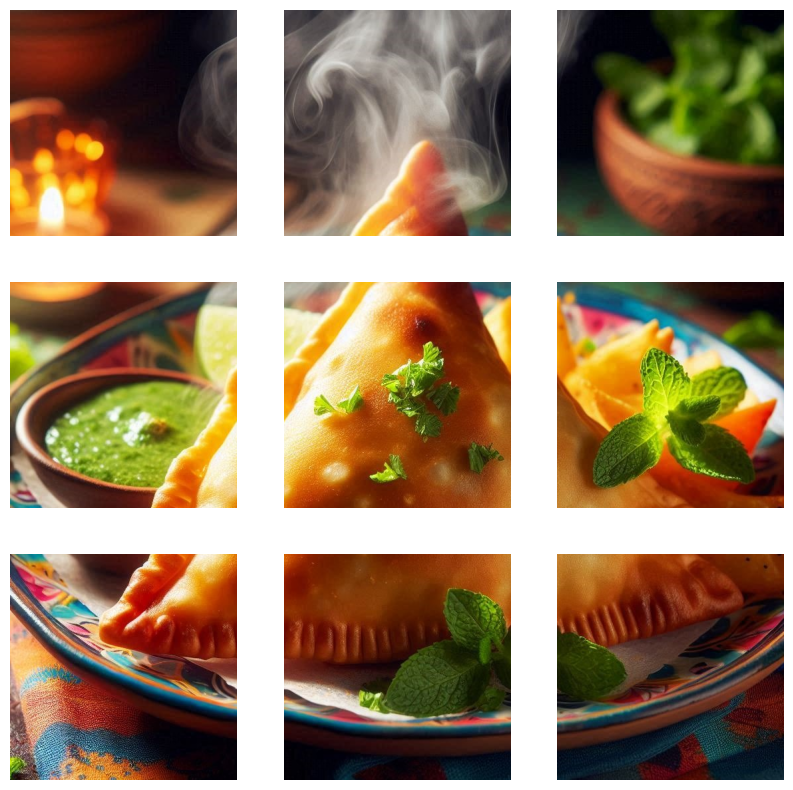

In [33]:
main('samosa.jpg')

### Testing Image 2

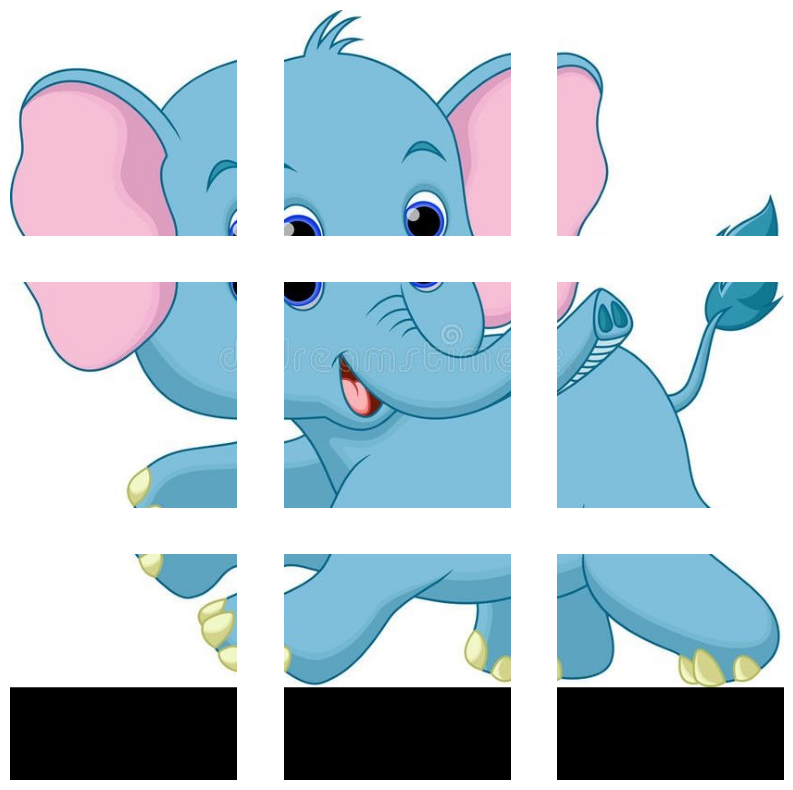

In [34]:
main('test3.jpg')

### Testing Image 3

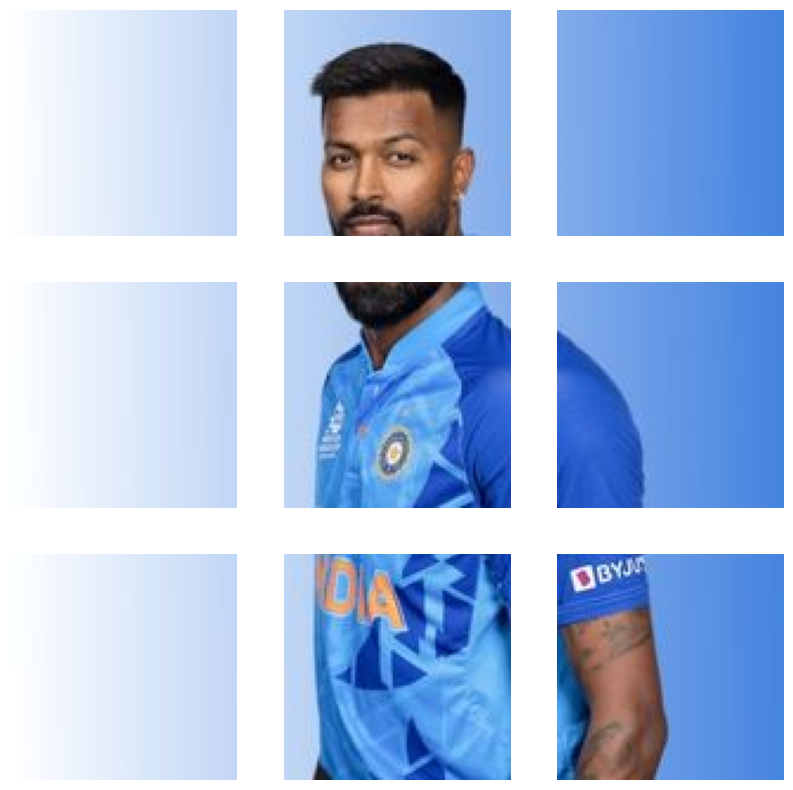

In [35]:
main('test.jpg')

<center>

## Part-2

</center>

<center>

### Implementing Feature Selection with stochastic optimization

</center>



### 1. Import requests
   - **Purpose**: This line imports the `requests` library into the script.
   - **Explanation**:
     - **`requests`**: The `requests` library is a popular and user-friendly HTTP library in Python, commonly used to make HTTP requests (such as GET, POST) to external APIs or web servers.
     - **How it's used**: The `requests` library is used to send HTTP requests and receive responses. In the context of the code provided, it is used to make a **GET request** to the Spoonacular API to fetch recipes based on user-provided ingredients.
     - **Benefits**:
       - It simplifies the process of interacting with web APIs by handling the complexities of making HTTP requests (like URL encoding, authentication, handling responses).
       - With the `requests.get()` method, you can easily send a GET request to retrieve data from an API and get the response in a simple Python object (like a dictionary, if the response is in JSON format).
   
### 2. Import random
   - **Purpose**: This line imports the `random` module into the script.
   - **Explanation**:
     - **`random`**: The `random` module is a built-in Python library that implements pseudo-random number generators and various randomization functions.
     - **How it's used**: In the context of the script, the `random` module is used to select random recipes or to perform random operations, such as:
       - `random.sample()`: This function is used to randomly select a subset of recipes from a larger list.
       - `random.randint()`: This function can be used to select random numbers, which can be useful for randomizing things like the number of recipes to fetch or the index of a selected recipe.
     - **Benefits**:
       - Randomness helps introduce variability or unpredictability in scenarios like selecting recipes or generating features for the stochastic feature selection process (which looks for the best set of recipes based on user preferences).

### In Context:
- **`requests`** is essential for interacting with the Spoonacular API to fetch recipe data, while **`random`** is used to introduce random behavior, particularly when selecting recipes or features (like randomly selecting a subset of recipes for evaluation in stochastic feature selection).

In [36]:
import requests
import random



### 1. **`API_KEY = '088470edd50041399681e5cb3f9b5bc7'`**
   - **Purpose**: This variable stores the API key needed to authenticate requests to the Spoonacular API. The API key is like a password that grants access to the service.
   
### 2. **`API_URL = 'https://api.spoonacular.com/recipes/complexSearch'`**
   - **Purpose**: This variable defines the URL endpoint of the Spoonacular API that will be used to search for recipes.
   
### **How it's used**:
 When making a GET request to this URL, the request can include various parameters (like ingredients, number of recipes, dietary restrictions) to refine the search. This URL is where the API request will be sent in order to retrieve relevant recipe data.

### In Context:
The combination of these two variables enables the program to interact with the Spoonacular API by sending requests to the defined URL, including the API key for authentication. When making a request to the API, the `API_KEY` is passed along to ensure the user has valid access to Spoonacular's services, and `API_URL` is the target endpoint where the request is sent to search for recipes based on the parameters provided (such as ingredients).



In [37]:
API_KEY = '088470edd50041399681e5cb3f9b5bc7'
API_URL = 'https://api.spoonacular.com/recipes/complexSearch'

### 1. fetch_recipes(ingredients)
   - **Purpose**: This function fetches a list of recipes from the Spoonacular API based on the ingredients you provide.
   - **Input**: A list of ingredients (`ingredients`), which are used to search for recipes.
   - **Process**:
     - The `params` dictionary is set with the following:
       - `query`: A comma-separated string of ingredients (joined from the `ingredients` list).
       - `number`: Limits the number of recipes to fetch (set to 10 in this case).
       - `apiKey`: The API key needed to authenticate the request to Spoonacular API.
     - The `requests.get()` function sends the GET request to the Spoonacular API with these parameters.
     - If the response status is **successful** (status code 200), the function extracts the recipes from the `results` field in the JSON response using `response.json().get('results', [])`. This returns a list of recipes.
     - If the API request fails, the function prints an error message and returns an empty list.
   - **Output**: Returns a list of recipes (if successful) or an empty list (if an error occurred).

In [38]:
def fetch_recipes(ingredients):
    params = {
        'query': ','.join(ingredients),  # Use query instead of ingredients
        'number': 10,  # Number of recipes to fetch
        'apiKey': API_KEY,
    }
    response = requests.get(API_URL, params=params)

    if response.status_code == 200:
        recipes = response.json().get('results', [])  # Extract the 'results' field
        return recipes
    else:
        print(f"Error fetching recipes: {response.json()}")
        return []

### 2. score_recipe(recipe, user_ingredients, dietary_restrictions)
   - **Purpose**: This function assigns a score to each recipe based on how well it matches the user’s ingredients and dietary restrictions.
   - **Input**:
     - `recipe`: A single recipe object (from the Spoonacular API).
     - `user_ingredients`: A list of ingredients that the user has available.
     - `dietary_restrictions`: A list of dietary restrictions (e.g., 'vegan', 'gluten-free').
   - **Process**:
     - The function first checks the ingredients used in the recipe. It extracts the `usedIngredients` field from the recipe.
     - Then, it calculates a score based on how many of the user's ingredients appear in the recipe's used ingredients. This is done by finding the intersection of the two sets (`used_ingredients` and `user_ingredients`) and counting the number of common ingredients.
     - The function also checks if the recipe is marked as **vegan** (`recipe.get('vegan')`) and if the user has specified a vegan dietary restriction. If both conditions are true, it adds an additional point to the score.
   - **Output**: Returns a score for the recipe (higher score means a better match).

In [39]:
def score_recipe(recipe, user_ingredients, dietary_restrictions):
    # Check if 'usedIngredients' is in the recipe
    used_ingredients = recipe.get('usedIngredients', [])
    score = len(set(used_ingredients) & set(user_ingredients))
    
    if recipe.get('vegan') and 'vegan' in dietary_restrictions:
        score += 1
    return score


### 3. Stochastic_feature_selection(recipes, user_ingredients, dietary_restrictions)
   - **Purpose**: This function applies a **stochastic feature selection** algorithm to select a subset of recipes that best match the user's ingredients and dietary restrictions.
   - **Input**:
     - `recipes`: A list of recipes fetched from the Spoonacular API.
     - `user_ingredients`: A list of ingredients the user has.
     - `dietary_restrictions`: A list of dietary restrictions (e.g., 'vegan', 'gluten-free').
   - **Process**:
     - The function begins by initializing `best_features` to `None` and `best_score` to -1 (representing the worst possible score).
     - It then runs for 100 iterations (as set by `range(100)`):
       - In each iteration, it randomly selects a subset of recipes (between 1 and 5 recipes) using `random.sample()`.
       - It calculates the total score for the subset of recipes by summing up the individual recipe scores using the `score_recipe()` function.
       - If the current subset of recipes has a higher total score than the best score found so far, it updates the `best_features` with this subset and updates the `best_score`.
   - **Output**: Returns the best subset of recipes (those with the highest score based on the user’s ingredients and dietary restrictions).

In [40]:
def stochastic_feature_selection(recipes, user_ingredients, dietary_restrictions):
    best_features = None
    best_score = -1
    
    for _ in range(100):  # Number of iterations
        # Randomly select a subset of recipes as features
        current_features = random.sample(recipes, k=random.randint(1, min(5, len(recipes))))  # Ensure we don't exceed recipe count
        current_score = sum(score_recipe(r, user_ingredients, dietary_restrictions) for r in current_features)
        
        if current_score > best_score:
            best_score = current_score
            best_features = current_features

    return best_features

### 4. main()
   - **Purpose**: This is the main function that brings everything together. It defines the user’s ingredients and dietary restrictions, fetches recipes, scores them, and finally recommends the best recipes.
   - **Input**: It uses hardcoded values for `user_ingredients` and `dietary_restrictions` (which can be replaced by user input).
   - **Process**:
     - First, it defines the `user_ingredients` (e.g., `['chicken', 'rice', 'broccoli']`) and `dietary_restrictions` (e.g., `['gluten-free']`).
     - It then calls the `fetch_recipes()` function to retrieve recipes from the Spoonacular API.
     - If recipes are fetched successfully, it passes them to `stochastic_feature_selection()` to select the best matching recipes based on the user’s ingredients and dietary restrictions.
     - If there are recommended recipes, it prints the titles of the recommended recipes. If no recipes are found or suitable, it prints a message indicating so.
     - If no recipes are fetched from the API, it prints an error message.
   - **Output**: Displays the titles of the recommended recipes or an appropriate message if no recipes are found.

In [41]:

def main():
    user_ingredients = ['chicken', 'rice', 'broccoli']
    dietary_restrictions = ['gluten-free']
    
    recipes = fetch_recipes(user_ingredients)
    
    if recipes:
        recommended_recipes = stochastic_feature_selection(recipes, user_ingredients, dietary_restrictions)
        
        if recommended_recipes:
            print("Recommended Recipes:")
            for recipe in recommended_recipes:
                print(recipe['title'])
        else:
            print("No suitable recipes found.")
    else:
        print("No recipes fetched.")

### 5. **`if _name_ == '_main_':`**
   - **Purpose**: This conditional check ensures that the `main()` function runs only when the script is executed directly, not when it is imported as a module in another script.
   - **Process**:
     - If the script is run directly (i.e., not imported), the `main()` function will be executed.
   - **Output**: Executes the main function.
   ### Example Flow of Execution:
   1. **User Input**: The user has ingredients `['chicken', 'rice', 'broccoli']` and dietary restrictions `['gluten-free']`.
2. **Fetching Recipes**: The `fetch_recipes()` function sends a request to the Spoonacular API and retrieves 10 recipes based on these ingredients.
3. **Scoring Recipes**: For each recipe, the `score_recipe()` function assigns a score based on ingredient matches and dietary restrictions.
4. **Selecting the Best Recipes**: The `stochastic_feature_selection()` function selects a subset of recipes and calculates the total score for each subset over 100 iterations.
5. **Displaying Results**: The titles of the best-matched recipes are printed.

In [42]:
if __name__ == '__main__':
    main()

Recommended Recipes:
Cumin-Scented Stir Fry
Lemon Pilaf Chicken
Ginger Chicken Stir-Fry
Chili and Garlic Spiced Beef and Broccoli Stir Fry
